In [ ]:
#pip install pmdarima

# CPI State Space Model Using ARIMA Method

[10 year US Government Bond Yields (long-term interest rate)](https://datahub.io/core/bond-yields-us-10y#readme)
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

### Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.

In [16]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#matplotlib.rcParams['figure.figsize'] = [8, 3]
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#from matplotlib import rcParams
#from cycler import cycler

#rcParams['figure.figsize'] = 18, 5
#rcParams['axes.spines.top'] = True
#rcParams['axes.spines.right'] = True
#rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
#rcParams['lines.linewidth'] = 2.5

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2


In [160]:
# read in cpi data\
month = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data/cpi_avg_price_data.csv', parse_dates=['Year'], index_col='Year')
       
print(month.shape)
month .head()

(110, 13)


,Series ID,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,,
1913-01-01,CUUR0000SA0,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0
1914-01-01,CUUR0000SA1,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1
1915-01-01,CUUR0000SA2,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3
1916-01-01,CUUR0000SA3,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6
1917-01-01,CUUR0000SA4,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7


In [161]:
month = month.drop('Series ID', axis=1)

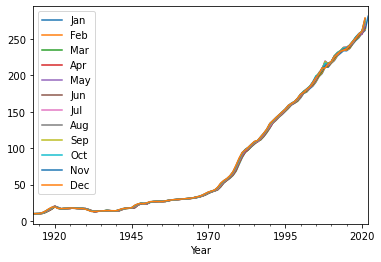

In [162]:
month.plot();

In [163]:
months = month[:-2]
months

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1913-01-01,9.800,9.800,9.800,9.800,9.700,9.800,9.900,9.900,10.000,10.000,10.100,10.000
1914-01-01,10.000,9.900,9.900,9.800,9.900,9.900,10.000,10.200,10.200,10.100,10.200,10.100
1915-01-01,10.100,10.000,9.900,10.000,10.100,10.100,10.100,10.100,10.100,10.200,10.300,10.300
1916-01-01,10.400,10.400,10.500,10.600,10.700,10.800,10.800,10.900,11.100,11.300,11.500,11.600
1917-01-01,11.700,12.000,12.000,12.600,12.800,13.000,12.800,13.000,13.300,13.500,13.500,13.700
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432
2017-01-01,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524
2018-01-01,247.867,248.991,249.554,250.546,251.588,251.989,252.006,252.146,252.439,252.885,252.038,251.233


**Task**: Either use univariate or multivariate time series analysis.
If multivariate incorporate method to sum or average annual value for specific year

In [164]:
len(months.columns)

12

In [165]:
months.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 1913-01-01 to 2020-01-01
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Jan     108 non-null    float64
 1   Feb     108 non-null    float64
 2   Mar     108 non-null    float64
 3   Apr     108 non-null    float64
 4   May     108 non-null    float64
 5   Jun     108 non-null    float64
 6   Jul     108 non-null    float64
 7   Aug     108 non-null    float64
 8   Sep     108 non-null    float64
 9   Oct     108 non-null    float64
 10  Nov     108 non-null    float64
 11  Dec     108 non-null    float64
dtypes: float64(12)
memory usage: 11.0 KB


In [222]:
# Sum each row for univariate analysis
month = months.sum(axis=1)
month['CPI'] = month[month[:-1]]

Year
1913-01-01     118.600
1914-01-01     120.200
1915-01-01     121.300
1916-01-01     130.600
1917-01-01     153.900
                ...   
2015-01-01    2844.204
2016-01-01    2880.086
2017-01-01    2941.435
2018-01-01    3013.282
2019-01-01    3067.889
Length: 107, dtype: float64


### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

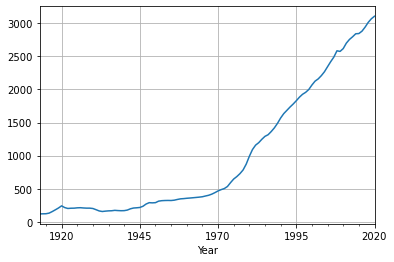

In [169]:
month.plot(grid=True);

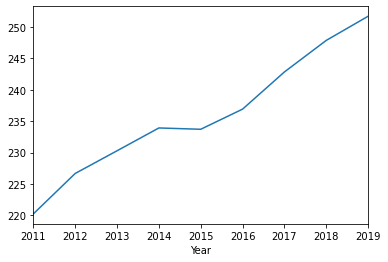

In [173]:
# 2011 - 2019
months["Jan"][-10:-1].plot();

In [174]:
month['Cpi'] = months['Jan']

In [175]:
# Train and test set
train = month['Cpi'].iloc[ :105]
test = month['Cpi'].iloc[105:]

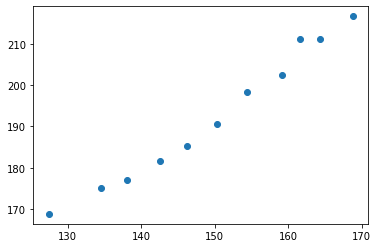

In [176]:
# Comparing 2 previous decades
plt.scatter(month['Cpi']['1990':'2000'], month['Cpi']['2000':'2010']);

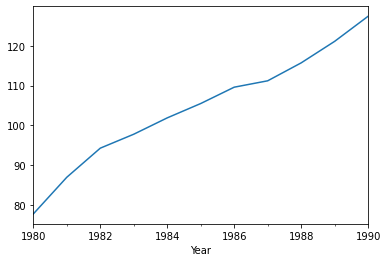

In [177]:
month['Cpi']['1980':'1990'].plot();

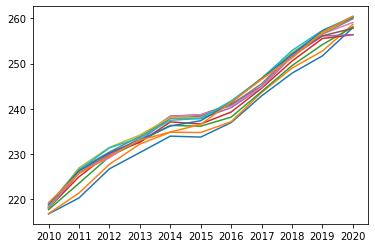

In [133]:
plt.plot(month['2010':'2020']);

In [178]:
month['Cpi']

Year
1913-01-01      9.800
1914-01-01     10.000
1915-01-01     10.100
1916-01-01     10.400
1917-01-01     11.700
               ...   
2016-01-01    236.916
2017-01-01    242.839
2018-01-01    247.867
2019-01-01    251.712
2020-01-01    257.971
Name: Jan, Length: 108, dtype: float64


### Test for Stationarity

To be capable of applying an **ARIMA** method, we will first need to add stationarity. First let's confirm that our time series is not stationary. A few methods exist for this, but we will use the **KPSS** method.



In [179]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month['Cpi'])

(0.9608148277615423, True)

In [180]:
from statsmodels.tsa.stattools import adfuller
# We acquire greater results through adfuller

def adf_test(month):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(month['Cpi'], autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    

    
adf_test(month)

Results of Dickey-Fuller Test:
Test Statistic                   1.298417
p-value                          0.996600
#Lags Used                       5.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [181]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month['Cpi'], regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
    
kpss_test(month)

Results of KPSS Test:
Test Statistic           0.410999
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


In [182]:
# Reject the null hypothesis - test statistic actual pvalue smaller
#sm.tsa.stattools.kpss(month, regression='ct')

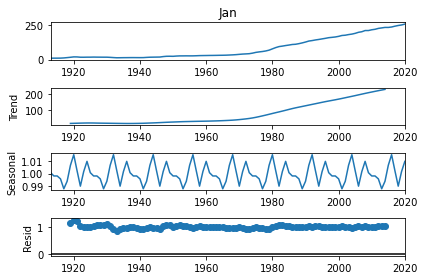

In [184]:
from statsmodels.tsa.seasonal import seasonal_decompose

seas_dcomp = seasonal_decompose(month['Cpi'],period=12,model='multiplicative')
seas_dcomp.plot();

# Apply Exponential Smoothing

ARIMA method not returning good predictions, possibly due <br>to no level of seasonality within the data.

Current solution: Use data that will fit the model


### Make Series Stationary


In [185]:
#Transform the data from non-statinary to stationary
month_log = np.sqrt(month['Cpi'])
month_diff = month_log.diff().dropna()

In [186]:
# Check for stationarity
result = adfuller(month_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -2.559826
p-value: 0.101588
Critical values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


In [187]:
result_kpss_ct_log=kpss(month_diff,regression="ct")
print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
print('p-value: %f' %result_kpss_ct_log[1])
print('Critical values:')
for key, value in result_kpss_ct_log[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.090000
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


In [ ]:
#month_new = month['Cpi']
#month_24 = month_new[777:-7]
#month_24.shape

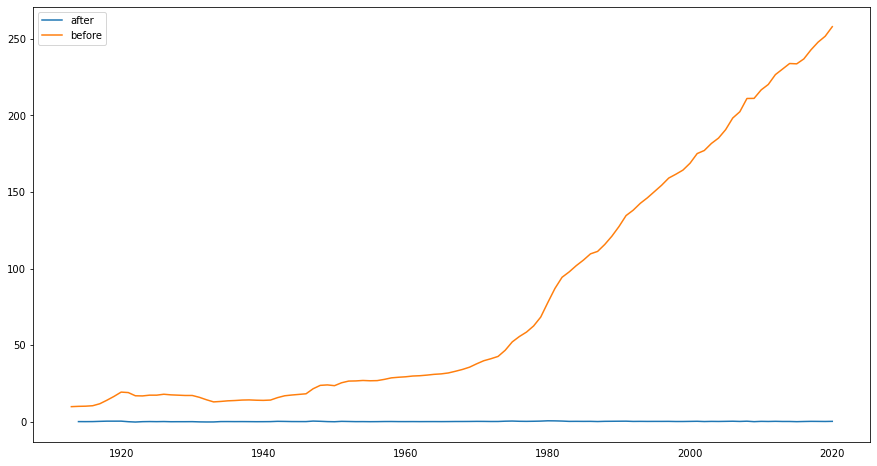

In [189]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month['Cpi'],label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()

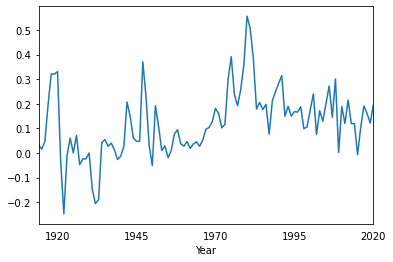

In [190]:
# Closer display
month_diff.plot()
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.show();


### ACF/PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [ ]:
# First order 
#month['Rate_diff'] = month['Rate'].diff(periods=12)
#month['Rate'] = month.dropna()

In [191]:
# Autocorrelation
acf_month = acf(month['Cpi'])
acf_month

array([ 1.00000000e+00,  9.71455342e-01,  9.43034806e-01,  9.14135189e-01,
        8.85254019e-01,  8.56696956e-01,  8.27849678e-01,  7.97802257e-01,
        7.67684102e-01,  7.37219883e-01,  7.06967370e-01,  6.76344560e-01,
        6.45988964e-01,  6.14423740e-01,  5.84103544e-01,  5.53744846e-01,
        5.24293620e-01,  4.95234989e-01,  4.66045150e-01,  4.37014993e-01,
        4.07381767e-01,  3.78353133e-01,  3.49640789e-01,  3.20758774e-01,
        2.91647881e-01,  2.62941205e-01,  2.34502426e-01,  2.06255757e-01,
        1.78090192e-01,  1.50290540e-01,  1.22806423e-01,  9.66204525e-02,
        7.14384986e-02,  4.70214765e-02,  2.31836446e-02, -4.80756783e-04,
       -2.33595419e-02, -4.57999443e-02, -6.77767536e-02, -8.91807924e-02,
       -1.09005795e-01])

Nice, we can definitely tell the difference, but let's see if we can do better

Most important is ?

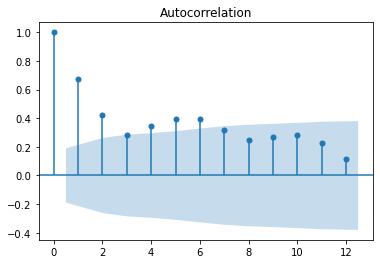

In [192]:
plot_acf(month_diff, lags=12);

In [193]:
# Partial autocorrelation
pacf_month = pacf(month['Cpi'])
pacf_month.round(2)

array([ 1.  ,  0.98, -0.02, -0.03, -0.02, -0.01, -0.03, -0.06, -0.03,
       -0.03, -0.02, -0.04, -0.02, -0.06,  0.01, -0.03, -0.  , -0.02,
       -0.04, -0.03, -0.06, -0.02, -0.03, -0.04, -0.05, -0.03, -0.04,
       -0.04, -0.05, -0.04, -0.04, -0.01, -0.01, -0.03, -0.03, -0.05,
       -0.03, -0.05, -0.05, -0.04, -0.  ])

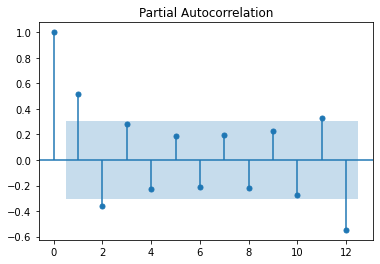

In [194]:
plot_pacf(pacf_month, lags=12);

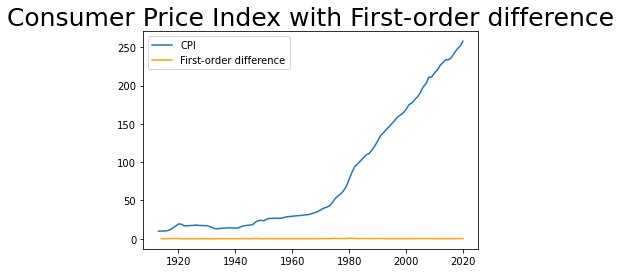

In [196]:
# Visualize our plots
plt.title('Consumer Price Index with First-order difference', size=25)
plt.plot(month['Cpi'], label='CPI')
plt.plot(month_diff, label='First-order difference', color='orange')
plt.legend();


## Auto-ARIMA

In [214]:
from pmdarima import auto_arima

month_fit = auto_arima(month_diff,start_p=1, d=0, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=100, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 50 )

month_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,1,0)[100] intercept   : AIC=-8.330, Time=1.28 sec
 ARIMA(0,0,0)(0,1,0)[100] intercept   : AIC=-7.901, Time=0.82 sec
 ARIMA(1,0,0)(1,1,0)[100] intercept   : AIC=-6.330, Time=5.96 sec
 ARIMA(0,0,1)(0,1,1)[100] intercept   : AIC=-6.621, Time=13.57 sec
 ARIMA(0,0,0)(0,1,0)[100]             : AIC=-8.228, Time=0.56 sec
 ARIMA(1,0,0)(0,1,1)[100] intercept   : AIC=-6.330, Time=7.35 sec
 ARIMA(1,0,0)(1,1,1)[100] intercept   : AIC=-4.330, Time=12.83 sec
 ARIMA(2,0,0)(0,1,0)[100] intercept   : AIC=-6.676, Time=2.16 sec
 ARIMA(1,0,1)(0,1,0)[100] intercept   : AIC=-6.811, Time=5.39 sec
 ARIMA(0,0,1)(0,1,0)[100] intercept   : AIC=-8.621, Time=4.02 sec
 ARIMA(0,0,1)(1,1,0)[100] intercept   : AIC=-6.621, Time=13.62 sec
 ARIMA(0,0,1)(1,1,1)[100] intercept   : AIC=-4.621, Time=19.11 sec
 ARIMA(0,0,2)(0,1,0)[100] intercept   : AIC=-6.777, Time=2.78 sec
 ARIMA(1,0,2)(0,1,0)[100] intercept   : AIC=-4.814, Time=2.57 sec
 ARIMA(0,0,1)(0,1,0)[100]    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  107
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 100)   Log Likelihood                   7.056
Date:                              Wed, 13 Jul 2022   AIC                            -10.112
Time:                                      23:50:16   BIC                            -10.220
Sample:                                           0   HQIC                           -11.449
                                              - 107                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9681      4.180      0.232      0.817      -7.224       9.160
sigma2         0.0059      0.023      0.258      0.796      -0.039       0.050
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.79   Prob(JB):                         0.65
Heteroskedasticity (H):               1.93   Skew:                             0.65
Prob(H) (two-sided):                  0.68   Kurtosis:                         1.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


## SARIMAX

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the other is P,D,Q,m to accountfor seasonality.

In [210]:
# Split data into train / test sets
#train = month['Cpi'].iloc[:len(month['Cpi'])-12]
#test = month['Cpi'].iloc[len(month['Cpi'])-12:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train, 
                order = (2, 1, 1))
  
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93794D+00    |proj g|=  2.06881D-02

At iterate    5    f=  1.93533D+00    |proj g|=  5.39602D-02

At iterate   10    f=  1.93204D+00    |proj g|=  1.58452D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   4.631D-06   1.932D+00
  F =   1.9320414850953616     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Jan   No. Observations:                  105
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -202.864
Date:                Wed, 13 Jul 2022   AIC                            413.729
Time:                        23:38:50   BIC                            424.306
Sample:                    01-01-1913   HQIC                           418.014
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2109      0.163      1.290      0.197      -0.110       0.531
ar.L2          0.6390      0.145      4.419      0.000       0.356       0.922
ma.L1          0.3929      0.203      1.936      0.053      -0.005       0.791
sigma2         2.8518      0.319      8.938      0.000       2.226       3.477
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                13.38
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               4.53   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

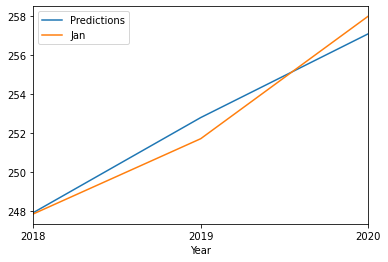

In [215]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

In [216]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
# Mse - always non-negative and values close to zero are better
# Incorporates both the variance of the estimator and its bias.

rmse(test, predictions)
mean_squared_error(test, predictions)

0.6599693464243701

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.21803D-01    |proj g|=  1.72747D+00

At iterate    5    f= -5.47862D-01    |proj g|=  2.46768D-01

At iterate   10    f= -5.53599D-01    |proj g|=  2.95641D-02


 This problem is unconstrained.



At iterate   15    f= -5.54483D-01    |proj g|=  2.17798D-01

At iterate   20    f= -5.55024D-01    |proj g|=  1.08743D-01

At iterate   25    f= -5.58160D-01    |proj g|=  5.52938D-01

At iterate   30    f= -5.72245D-01    |proj g|=  1.74922D-01

At iterate   35    f= -5.75929D-01    |proj g|=  5.21963D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     53      1     0     0   2.295D-03  -5.761D-01
  F = -0.57606391255235079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


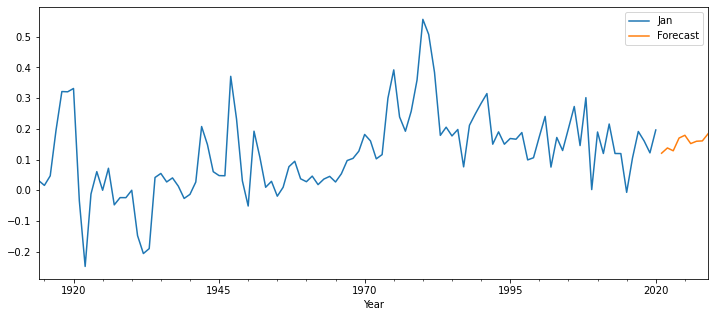

In [217]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 3
                          , 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);



### Alternate version


In [218]:
mod = sm.tsa.statespace.SARIMAX(month['Cpi'], order=(2,1,0), seasonal_order=(1,1,0,100), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         D.DS100.Jan   No. Observations:                    7
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 100)   Log Likelihood                 -15.771
Date:                             Wed, 13 Jul 2022   AIC                             39.542
Time:                                     23:58:43   BIC                             39.326
Sample:                                 01-01-2014   HQIC                            36.868
                                      - 01-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3981      0.579      0.688      0.491      -0.736       1.532
ar.L2          0.3421      

In [219]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci

,lower D.DS100.Jan,upper D.DS100.Jan
2014-01-01,-5.736895,5.736895
2015-01-01,-2.487733,6.646482
2016-01-01,-3.239148,5.343961
2017-01-01,-3.239052,5.344058
2018-01-01,-1.455770,7.127340
2019-01-01,-1.623910,6.959199
2020-01-01,-2.822815,5.760294
